In [17]:
%matplotlib inline
%load_ext autoreload
%autoreload 5
%autosave 15

import sklearn as sk
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from numpy.linalg import inv, det
from math import pi, sqrt
from copy import copy
import math
import pickle
import random


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 15 seconds


In [18]:
def open_pickle(name):
    with open(name, 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        x, y = u.load()
        return (x, y)

def graph(func, x_range, label):  
    x = np.array(x_range)  
    y = np.apply_along_axis(func, 0, x)
    plt.plot(x, y, label=label)
    plt.legend(loc='best')

def diff(a, b):
    res = 0
    for i in range(len(a)):
        res += (a[i] - b[i]) ** 2
    res = sqrt(res / len(a))
    return res
    
def kfold(k, x, y, linear_regression):
    p = np.concatenate((x, y), axis=1)
    random.shuffle(p)
    res = 0
    folds = [[] for _ in range(k)]
    for i in range(len(p)):
        folds[i % k].append(p[i])
    folds = np.array(folds)
    for i in range(k):
        train = []
        for j in range(k):
            if i == j:
                continue
            train.extend(folds[j])
        lr = copy(linear_regression)
        lr.fit(train)
        ans = lr.predict(folds[i][:,:-1])
        res += diff(ans, folds[i][:,-1])
    res = res / k
    return res

def loo(x, y, linear_regression):
    return kfold(len(y), x, y, linear_regression)
        

In [19]:
class LinearRegression:
    def __init__(self, mod, funcs=None, max_pow=None):
        if mod == "linear":
            self.mod = "linear"
        elif mod == "polinom" and max_pow != None:
            self.mod = "polinom"
            self.max_pow = max_pow
        elif mod == "func" and funcs != None:
            self.mod = "func"
            self.funcs = funcs
        else:
            raise ValueError('wrong mod: ', mod, funcs, max_pow)
    
    #def fit(self, x, y):
    #def fit(self, points):
    def fit(self, a1, a2=None):
        if a2 is None:
            points = a1
        else:
            points = np.concatenate((a1, a2), axis=1)
        x = []
        y = []
        self.point_size = len(points[0])
        for p in points:
            y.append(p[-1])
            features = [1]
            for dim in p[:-1]:
                features.append(dim)
                if self.mod == 'polinom':
                    for power in range(2, self.max_pow + 1):
                        features.append(dim ** power)
                elif self.mod == 'func':
                    for func in self.funcs:
                        features.append(func(dim))
            x.append(features)
        x = np.array(x)
        y = np.array(y)
        t = x.T
        b = np.dot(np.dot(inv(np.dot(t, x)), t), y)
        self.ess = sum((np.dot(x, b.T) - y) ** 2)
        my = np.mean(y)
        self.tss = sum((my - y) ** 2)
        self.r2 = 1 - self.ess / self.tss
        self.b = b
    
    def predict(self, X):
        y = []
        for x in X:
            t = self.b[0]
            l = 1
            for dim in x:
                t += self.b[l] * dim
                l += 1
                if self.mod == 'polinom':
                    for power in range(2, self.max_pow + 1):
                        t += self.b[l] * dim ** power
                        l += 1
                elif self.mod == 'func':
                    for func in self.funcs:
                        t += self.b[l] * func(dim)
                        l += 1
            y.append(t)
        return y
        
    def info(self):
        print ("B: ", self.b, "\nR2: ", self.r2, "\nESS: ", self.ess, "\nTSS", self.tss, "\n")
        
    def get_func_dim1(self):
        if self.mod == 'linear':
            def f(x):
                return self.b[0] + self.b[1] * x
            return f
        elif self.mod == 'polinom':
            def f(x):
                res = self.b[0]
                for i in range(1, len(self.b)):
                    res += self.b[i] * x ** i
                return res
            return f
        elif self.mod == 'func':
            def f(x):
                res = self.b[0] + self.b[1] * x
                for i in range(2, len(self.b)):
                    res += self.b[i] * self.funcs[i - 2](x)
                return res
            return f

p = [[1, 0], [3, 1], [7, 3]]
lr = LinearRegression('linear')
lr.fit(p)
print("y=-1/2 + x/2\n")
lr.info()

p = [[0, 0], [-1, 1], [1, 1]]
lr = LinearRegression('polinom', max_pow=2)
lr.fit(p)
print("y = x^2\n")
lr.info()

p = [[-pi/2, -pi/2 + 2], [0, 3], [pi/2, pi/2 + 4], [pi, pi + 3]]
funcs = [lambda x: math.sin(x)]
lr = LinearRegression('func', funcs=funcs)
lr.fit(p)
print("y = 3 + x + sin(x)")
lr.info()


p = [[0, 0, 0], [1, 0, 1], [0, 1, 1], [4, 3, 25], [3, -4, 25], [-10, 0, 100]]
lr = LinearRegression('polinom', max_pow=2)
lr.fit(p)
print("z = x^2 + z^2")
lr.info()

y=-1/2 + x/2

B:  [-0.5  0.5] 
R2:  1.0 
ESS:  4.99201041585e-30 
TSS 4.66666666667 

y = x^2

B:  [ 0.  0.  1.] 
R2:  1.0 
ESS:  0.0 
TSS 0.666666666667 

y = 3 + x + sin(x)
B:  [ 3.  1.  1.] 
R2:  1.0 
ESS:  1.97215226305e-31 
TSS 20.6201908085 

z = x^2 + z^2
B:  [  1.22035715e-12  -6.66133815e-14   1.00000000e+00  -7.37188088e-14
   1.00000000e+00] 
R2:  1.0 
ESS:  8.9331512646e-24 
TSS 7401.33333333 



kfold cv 0.13076950719783195
loo cv 0.1073052973701364
B:  [ 4.00907274 -0.49868693] 
R2:  0.989532021467 
ESS:  5.73608676891 
TSS 547.965087117 



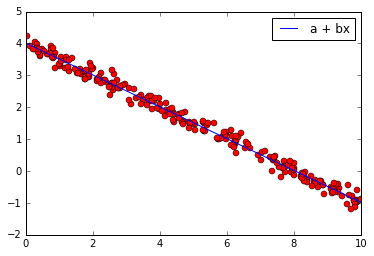

In [20]:
x, y = open_pickle('task2_dataset_1.txt')
plt.plot(x, y, 'ro')
lr = LinearRegression('linear')
print("kfold cv", kfold(5, x, y, lr))
print("loo cv", loo(x, y, lr))

lr.fit(x, y)
lr.info()
graph(lr.get_func_dim1(), range(math.floor(min(x)), math.ceil(max(x + 1))), 'a + bx')
plt.show()

a + b * x + c * tg(x/10)
kfold cv 0.46588288415036916
loo cv 0.3740971336955835
B:  [  -0.6556557    12.56996259 -130.92345074] 
R2:  0.983647313462 
ESS:  51.8909346767 
TSS 3173.23606459 

polinom 3
kfold cv 0.3115722146124448
loo cv 0.25450279297670186
B:  [-1.02167555 -0.49117246  0.0471008  -0.0503415 ] 
R2:  0.99288029882 
ESS:  22.5924925545 
TSS 3173.23606459 



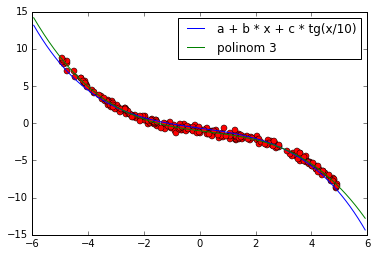

In [26]:
x, y = open_pickle('task2_dataset_2.txt')
plt.plot(x, y, 'ro')

funcs = [lambda x:np.tan(x/10)]
lr1 = LinearRegression(mod='func', funcs=funcs)
lr1.fit(x, y)
description = "a + b * x + c * tg(x/10)"
print(description)
print("kfold cv", kfold(5, x, y, lr1))
print("loo cv", loo(x, y, lr1))
lr1.info()
graph(lr1.get_func_dim1(), np.arange(min(x) - 1, max(x) + 1, 0.01), description)

P = 3
lr2 = LinearRegression(mod='polinom', max_pow=P)
lr2.fit(x, y)
description = "polinom %d" % P
print(description)
print("kfold cv", kfold(5, x, y, lr2))
print("loo cv", loo(x, y, lr2))
lr2.info()
graph(lr2.get_func_dim1(), np.arange(min(x) - 1, max(x) + 1, 0.01), description)

plt.show()

a + bx + c * sin x
kfold cv 0.25859064026488554
loo cv 0.20721231315104005
B:  [ 0.43721861  0.30332599  2.94484163] 
R2:  0.985080747168 
ESS:  17.8645994954 
TSS 1197.41918019 

polinom 9
kfold cv 0.199681314280394
loo cv 0.15981645688739374
B:  [ -5.29365356e+00   1.62199198e+01  -1.36418998e+01   7.64670097e+00
  -2.96355944e+00   7.07827794e-01  -9.96811566e-02   8.06299585e-03
  -3.47114073e-04   6.17765865e-06] 
R2:  0.99167418923 
ESS:  9.96948550694 
TSS 1197.41918019 



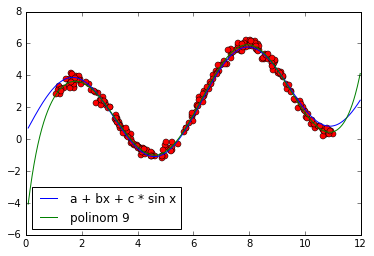

In [31]:
x, y = open_pickle('task2_dataset_3.txt')
plt.plot(x, y, 'ro')
p = np.concatenate((x, y), axis=1)

funcs = [lambda x:np.sin(x)]
description = "a + bx + c * sin x"
lr1 = LinearRegression(mod='func', funcs=funcs)
lr1.fit(x, y)
print(description)
print("kfold cv", kfold(5, x, y, lr1))
print("loo cv", loo(x, y, lr1))
lr1.info()
graph(lr1.get_func_dim1(), np.arange(min(x) - 1, max(x) + 1, 0.01), description)

P = 9
description = "polinom %d" % P
lr2 = LinearRegression(mod='polinom', max_pow=P)
lr2.fit(x, y)
print(description)
print("kfold cv", kfold(5, x, y, lr2))
print("loo cv", loo(x, y, lr2))
lr2.info()
graph(lr2.get_func_dim1(), np.arange(min(x) - 1, max(x) + 1, 0.01), description)

plt.show()